Now we have the pieces in place to acutally train a network to segment images for us. Let's do it!

In [1]:
from torch.utils.data import DataLoader
from data import DSBData, get_dsb2018_train_files

In [2]:
import torch
from monai.networks.nets import BasicUNet

In [3]:
train_img_files, train_lbl_files = get_dsb2018_train_files()

train_data = DSBData(
    image_files=train_img_files,
    label_files=train_lbl_files,
    target_shape=(256, 256)
)

print(len(train_data))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

100%|██████████████████████████████████████| 382/382 [00:20<00:00, 18.96it/s]


232


In [4]:
model = BasicUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    features=[16, 16, 32, 64, 128, 16],
    act="relu",
    norm="batch",
    dropout=0.25,
)

BasicUNet features: (16, 16, 32, 64, 128, 16).


Training of a neural network means updating its parameters (weights) using a strategy that involves the gradients of a loss function with respect to the model parameters in order to adjust model weights to minimize this loss.

In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=1.e-3)
init_params = list(model.parameters())[0].clone().detach()

Such a training is performed by iterating over the batches of the training dataset multiple times. Each full iteration over the dataset is termed an epoch.

In [6]:
max_nepochs = 1
log_interval = 1
model.train(True)

# expects raw unnormalized scores and combines sigmoid + BCELoss for better
# numerical stability.
# expects B x C x W x D
loss_function = torch.nn.BCEWithLogitsLoss(reduction="mean")

for epoch in range(1, max_nepochs + 1):
    for batch_idx, (X, y) in enumerate(train_loader):
        # print("train", batch_idx, X.shape, y.shape)

        optimizer.zero_grad()

        prediction_logits = model(X)
        
        batch_loss = loss_function(prediction_logits, y)

        batch_loss.backward()

        optimizer.step()

        if batch_idx % log_interval == 0:
            print(
                "Train Epoch:",
                epoch,
                "Batch:",
                batch_idx,
                "Total samples processed:",
                (batch_idx + 1) * train_loader.batch_size,
                "Loss:",
                batch_loss.item(),
            )

Train Epoch: 1 Batch: 0 Total samples processed 32 Loss: 0.7636604309082031
Train Epoch: 1 Batch: 1 Total samples processed 64 Loss: 0.7316972017288208
Train Epoch: 1 Batch: 2 Total samples processed 96 Loss: 0.6992580890655518
Train Epoch: 1 Batch: 3 Total samples processed 128 Loss: 0.6787922382354736
Train Epoch: 1 Batch: 4 Total samples processed 160 Loss: 0.6548287868499756
Train Epoch: 1 Batch: 5 Total samples processed 192 Loss: 0.6310180425643921
Train Epoch: 1 Batch: 6 Total samples processed 224 Loss: 0.6482836604118347
Train Epoch: 1 Batch: 7 Total samples processed 256 Loss: 0.6311068534851074


In [7]:
final_params = list(model.parameters())[0].clone().detach()
assert not torch.allclose(init_params, final_params)

## Look at some predictions

Now that the model has been trained for a little bit, we are looking at the predictions again. Usually model training has to be peformed longer, so don't expect any wonders. Also keep in mind that the predictions here are based on the data the model was trained on. Those predictions might be far better than those on data not used during training. But this is a story for later.

In [10]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Predictions')

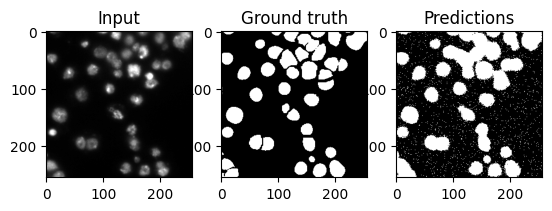

In [12]:
# convert to 0/1 range on each pixel
prediction = torch.nn.functional.sigmoid(prediction_logits)
prediction_binary = (prediction > 0.5).to(torch.uint8)

sidx = 0
plt.subplot(131)
plt.imshow(X[sidx, 0].numpy(), cmap="gray")
plt.title("Input")

plt.subplot(132)
plt.imshow(y[sidx, 0].numpy(), cmap="gray")
plt.title("Ground truth")

plt.subplot(133)
plt.imshow(prediction_binary.detach()[sidx, 0].numpy(), cmap="gray")
plt.title("Predictions")